In [6]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

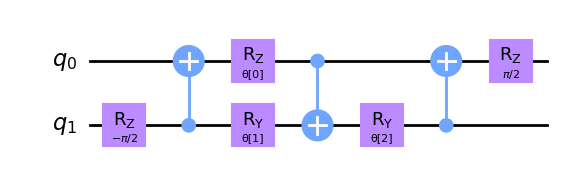

In [7]:
#Function to create the gates with parameters that we will modify through ML techniques
def parametrized_gates(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

#Draws the ciruit for parametrized gate
params = ParameterVector("θ", length=3)
circuit = parametrized_gates(params)
circuit.draw("mpl", style="clifford")

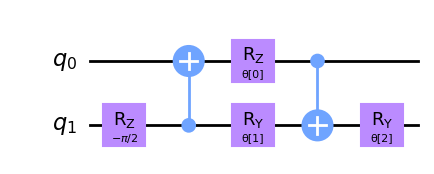

In [8]:
#Circuit to help with dimensionality reduction and combine two qubits into one
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

In [9]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

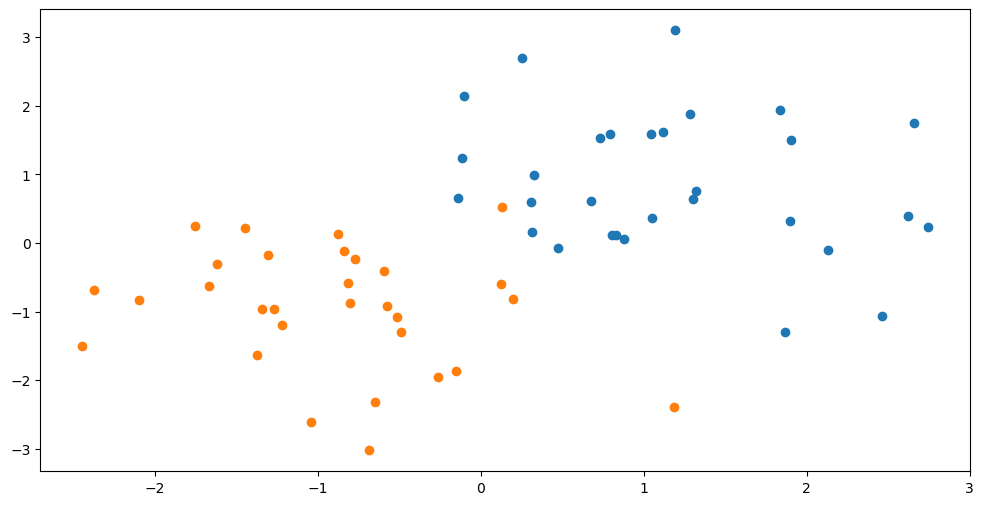

In [68]:
#Generates training data for classifier
#This is just to get a proof of concept. Eventually we can use the financial data
sample_size = 30
np.random.seed(1)
group0 = np.random.multivariate_normal([1,1], [[1, 0], [0, 1]], sample_size)
group1 = np.random.multivariate_normal([-1,-1], [[1, 0], [0, 1]], sample_size)
plt.scatter(group0[:,0], group0[:,1])
plt.scatter(group1[:,0], group1[:,1])
plt.show

data = np.concatenate((group0, group1))
labels = np.concatenate((np.ones(sample_size), np.zeros(sample_size)-1))

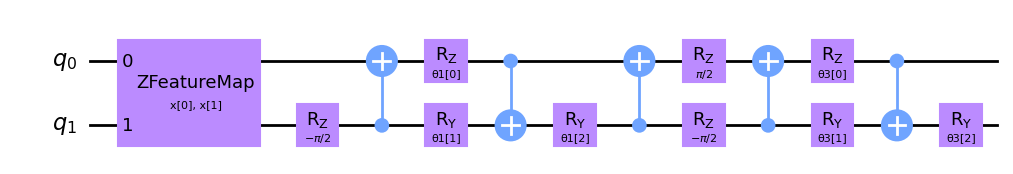

In [69]:
#Sets up full circuit with inputs and network
from qiskit.circuit.library import ZFeatureMap
feature_map = ZFeatureMap(2)
network = parametrized_gates(ParameterVector("θ1", length=3))
network.compose(pool_circuit(ParameterVector("θ3", length=3)), inplace=True)
ml_circuit = QuantumCircuit(2)
ml_circuit.compose(feature_map, inplace=True)
ml_circuit.compose(network, inplace=True)
ml_circuit.draw("mpl", style="clifford")

In [70]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from IPython.display import clear_output

In [71]:
#Sets up qiskit's neural network from the library
observable = SparsePauliOp.from_list([("Z" + "I", 1)])
qnn = EstimatorQNN(
    circuit=ml_circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=network.parameters,
)

In [72]:
#Function used in classifier to plot objective function at each iteration
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [73]:
#Sets up Classifier with COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),
    callback=callback_graph
)

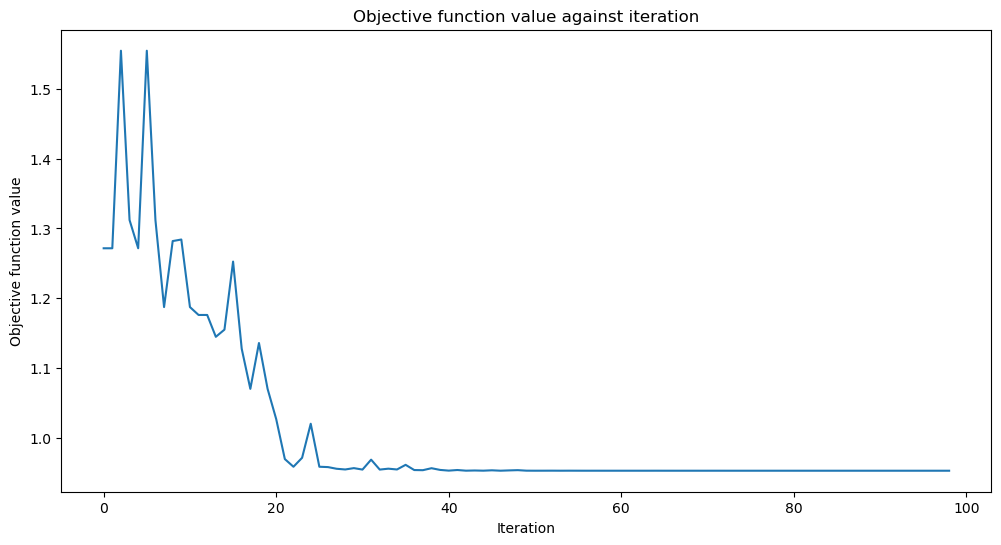

Accuracy from the train data : 56.67%


In [74]:
#Trains the network and plots objective function vs iteration
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(data, labels)
print(f"Accuracy from the train data : {np.round(100 * classifier.score(data, labels), 2)}%")

In [75]:
#First attempt at implementing something. Doesn't really perform well, gonna have to try new stuff

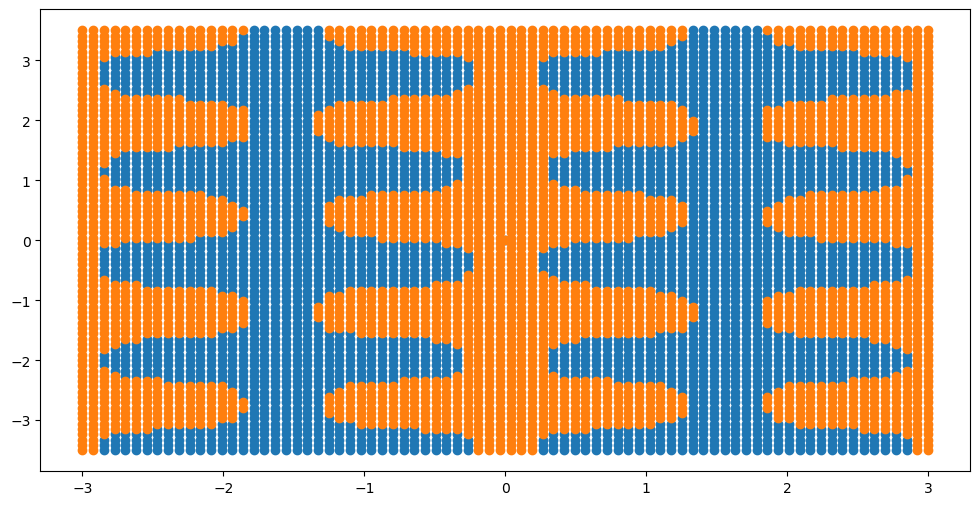

In [76]:
#Shows predictions across the whole plane. Really weird and not close to what we're aiming for
positive = np.array([[0],[0]])
negative = np.array([[0],[0]])
xAxis = np.linspace(-3,3,80)
yAxis = np.linspace(-3.5,3.5,80)
for i in xAxis:
    for j in yAxis:
        if classifier.predict([i,j]) == 1:
            positive = np.append(positive, [[i],[j]], axis=1)
        else:
            negative = np.append(negative, [[i],[j]], axis=1)
plt.scatter(negative[0,:], negative[1,:])
plt.scatter(positive[0,:], positive[1,:])